# Generative Models

## Conditional GAN

By Alireza Heidari

In this notebook, we are going to implement Conditional Generative Adversarial Network (CGAN) on the FashionMNIST dataset. To generate images, these models convert noise to images from the training distribution, but the key difference is that Diffusion models denoise the image gradually. The following sections briefly describe each generative model.

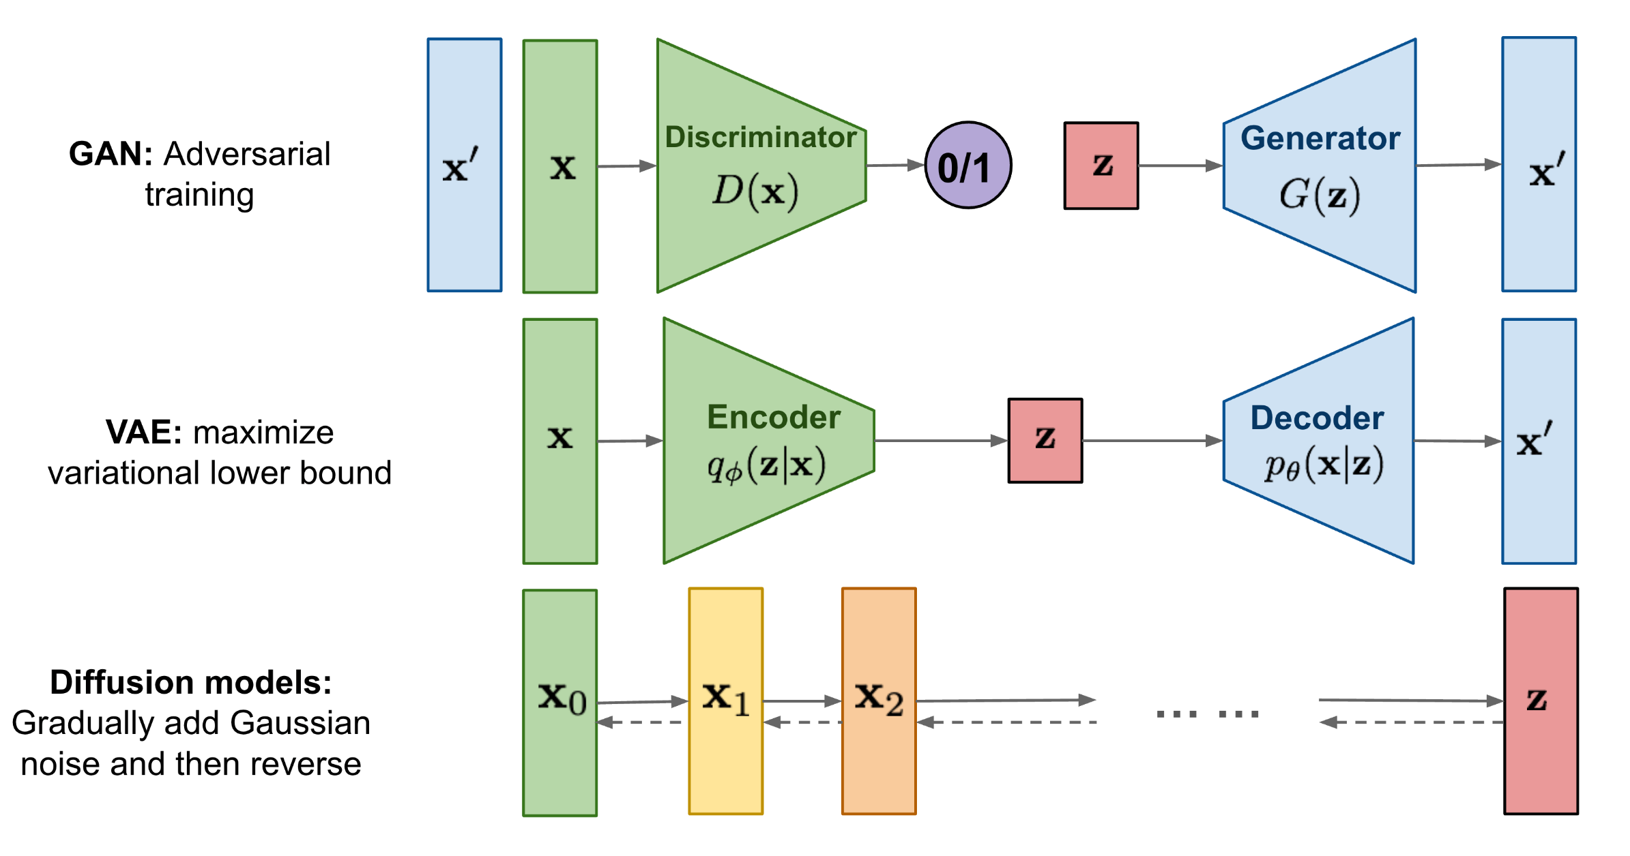 

## Dataset

We are going to work on the FashionMNIST dataset. FashionMNIST consists of a training set of 60,000 examples and a test set of 10,000 samples. Each sample is a 28x28 grayscale image associated with a label from 10 classes. We are going to use the training split in this notebook. You can use `dataloader` to train your models. Also, you can use `plot_samples` to plot a sequence of images.

### Initialization

In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchvision import transforms, utils
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
from tqdm import tqdm

BATCH_SIZE = 20
IMG_SIZE = 32 
C_IN = 1 # Number of input channels

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

In [2]:
DEVICE

'cuda'

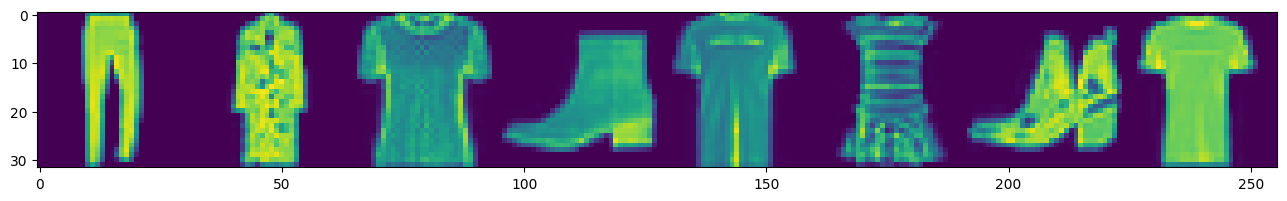

In [3]:
def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),  
        transforms.Lambda(lambda t: (t * 2) - 1)
    ]

    data_transform = transforms.Compose(data_transforms)

    data = torchvision.datasets.FashionMNIST(root=".", download=True, 
                                         train=True, transform=data_transform)
    return data


def plot_images(images):
    plt.figure(figsize=(16, 3))
    plt.imshow(torch.cat([
        torch.cat([i for i in images], dim=-1)
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()


data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, 
                        shuffle=True, drop_last=True)
batch_x, batch_y = next(iter(dataloader))
plot_images(batch_x[:8])

### GAN

GAN's architecture consists of a Discriminator and a Generator. The Discriminator identifies whether an input image ($x$) is real or generated by the Generator. The Generator tries to create fake images given a random noise ($z$) such that the Discriminator can not distinguish them from the real images. These functionalities give rise to an adversarial situation where these networks can be seen as players. Thus, the standard loss for GAN is the following min-max loss. The Generator tries to minimize it, while the Discriminator tries to maximize it.

$$ \min_{\theta_g} \max_{\theta_d} E_{x \sim p_{data}}[log(D_{\theta_d}(x)] + E_{z \sim p(z)}[log(1 - D_{\theta_d}(G_{\theta_g}(z)))] $$

We try to optimize this loss function by alternating between the following objectives for the Discriminator and the Generator:
+ Discriminator's objective:
 $$ \max_{\theta_d} E_{x \sim p_{data}}[log(D_{\theta_d}(x)] + E_{z \sim p(z)}[log(1 - D_{\theta_d}(G_{\theta_g}(z)))] $$
+ Generator's objective:
$$ \min_{\theta_g} E_{z \sim p(z)}[log(1 - D_{\theta_d}(G_{\theta_g}(z)))] $$

Each player’s cost depends on the parameters of the other player. However, each
player can only optimize its own parameters.

### ❓ **Question**
> - **How can we generate images from a specific class in GAN?**

To generate images from a specific class in a GAN, we can add a conditioning variable to the generator and the discriminator, which encodes (Embedding) the class label of the image we want to generate. This conditioning variable can be concatenated with the noise vector in the generator and with the image tensor in the discriminator, during training.

### Conditional GAN

In [4]:
class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim=64, img_size=32, hidden_dim=128, n_classes=10):
        super(ConditionalGenerator, self).__init__()
        self.img_size = img_size
        self.embed = nn.Embedding(n_classes, n_classes)

        self.layers = nn.Sequential(
            nn.Linear(latent_dim + n_classes, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.BatchNorm1d(hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim * 4, img_size * img_size),
            nn.Tanh()
        )

    def forward(self, z, labels):
        labels = self.embed(labels)
        x = torch.cat([z, labels], 1)
        img = self.layers(x)
        img = img.view(-1, 1, self.img_size, self.img_size)
        return img

class ConditionalDiscriminator(nn.Module):
    def __init__(self, img_size=32, hidden_dim=128, n_classes=10):
        super(ConditionalDiscriminator, self).__init__()
        self.img_size = img_size
        self.hidden_dim = hidden_dim
        self.embed = nn.Embedding(n_classes, n_classes)

        self.layers = nn.Sequential(
            nn.Linear(img_size * img_size + n_classes, hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        img = img.view(-1, self.img_size * self.img_size)
        labels = self.embed(labels)
        x = torch.cat([img, labels], 1)
        real_or_fake = self.layers(x)
        return real_or_fake

### Training

In [5]:
class ConditionalGANManager():
    def __init__(self, img_size=32, latent_dim=64, hidden_dim=128, lr=0.0001, n_classes=10):
        self.latent_dim = latent_dim
        self.n_classes = n_classes
        self.generator = ConditionalGenerator(latent_dim=latent_dim, img_size=img_size, hidden_dim=hidden_dim, n_classes=n_classes).to(DEVICE)
        self.discriminator = ConditionalDiscriminator(img_size=img_size, hidden_dim=hidden_dim, n_classes=n_classes).to(DEVICE)

        self.optimizer_G = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(0.5, 0.999))
        self.optimizer_D = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
        self.loss = nn.BCELoss()

    def plot_class_samples(self, n_samples=8):
        z = torch.randn((n_samples * self.n_classes, self.latent_dim), device=DEVICE)
        gen_labels = torch.tensor([i for i in range(self.n_classes) for _ in range(n_samples)], device=DEVICE)
        gen_imgs = self.generator(z, gen_labels)

        rearranged_imgs = torch.zeros((n_samples, self.n_classes, 32, 32), device=DEVICE)
        for i in range(self.n_classes):
            for j in range(n_samples):
                rearranged_imgs[j, i] = gen_imgs[i * n_samples + j].squeeze()

        self.plot_images_cgan(rearranged_imgs)

    def plot_images_cgan(self, images):
        n_samples, n_classes, h, w = images.shape
        img_grid = make_grid(images.view(-1, 1, h, w), nrow=n_classes, normalize=True)
        np_img = img_grid.cpu().numpy().transpose((1, 2, 0))
        plt.imshow(np_img)
        plt.axis('off')
        plt.show()


    def train(self, dataloader, epochs=100, sample_interval=937):
        real_labels = torch.ones((dataloader.batch_size,1), device=DEVICE)
        fake_labels = torch.zeros((dataloader.batch_size, 1), device=DEVICE)
        history = dict(g_loss=[], d_loss=[])
        for epoch in range(epochs):
            total_g_loss = []
            total_d_loss = []
            for i, (imgs, labels) in enumerate(tqdm(dataloader)):
                imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

                # Train the discriminator
                self.optimizer_D.zero_grad()

                # Real images
                real_preds = self.discriminator(imgs, labels)
                real_loss = self.loss(real_preds, real_labels)
                real_loss.backward()

                # Fake images
                z = torch.randn((dataloader.batch_size, self.latent_dim), device=DEVICE)
                gen_labels = torch.randint(0, self.n_classes, (dataloader.batch_size,), device=DEVICE)
                fake_imgs = self.generator(z, gen_labels)
                fake_preds = self.discriminator(fake_imgs.detach(), gen_labels)
                fake_loss = self.loss(fake_preds, fake_labels)
                fake_loss.backward()

                d_loss = real_loss + fake_loss
                self.optimizer_D.step()

                # Train the generator
                self.optimizer_G.zero_grad()

                fake_preds = self.discriminator(fake_imgs, gen_labels)
                g_loss = self.loss(fake_preds, real_labels)
                g_loss.backward()
                self.optimizer_G.step()

                total_g_loss.append(g_loss.item())
                total_d_loss.append(d_loss.item())

                if (i+1) % sample_interval == 0:
                    self.plot_class_samples()

            history['g_loss'].append(sum(total_g_loss)/len(total_g_loss))
            history['d_loss'].append(sum(total_d_loss)/len(total_d_loss))
            mean_d_loss = np.mean(total_d_loss)
            mean_g_loss = np.mean(total_g_loss)

            print(
                "[Epoch: %d/%d] [D loss: %.4f] [G loss: %.4f]"
                % (epoch+1, epochs, mean_d_loss, mean_g_loss)
            )

        return history

 99%|████████████████████████████████████████▊| 932/937 [00:12<00:00, 75.93it/s]

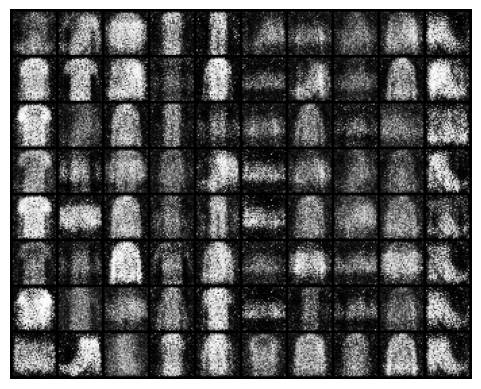

100%|█████████████████████████████████████████| 937/937 [00:12<00:00, 74.91it/s]


[Epoch: 1/30] [D loss: 1.0212] [G loss: 0.9722]


 99%|████████████████████████████████████████▋| 929/937 [00:12<00:00, 73.02it/s]

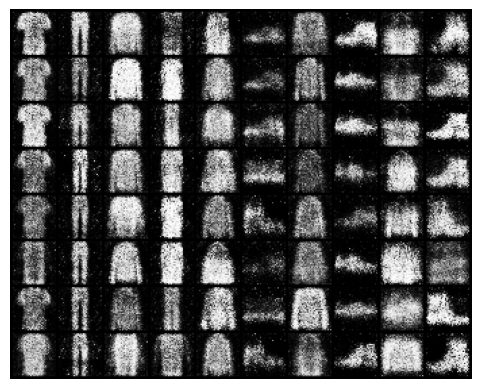

100%|█████████████████████████████████████████| 937/937 [00:12<00:00, 73.43it/s]


[Epoch: 2/30] [D loss: 0.9535] [G loss: 1.1563]


100%|████████████████████████████████████████▉| 935/937 [00:12<00:00, 73.12it/s]

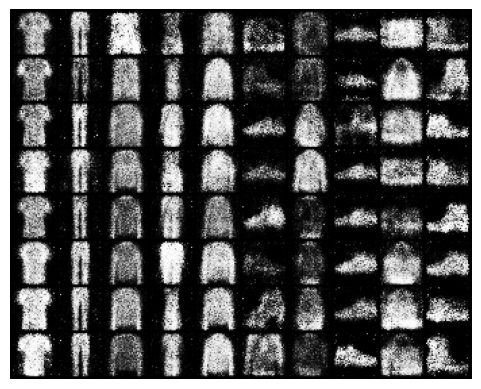

100%|█████████████████████████████████████████| 937/937 [00:12<00:00, 72.14it/s]


[Epoch: 3/30] [D loss: 0.9119] [G loss: 1.2767]


100%|████████████████████████████████████████▊| 933/937 [00:12<00:00, 72.78it/s]

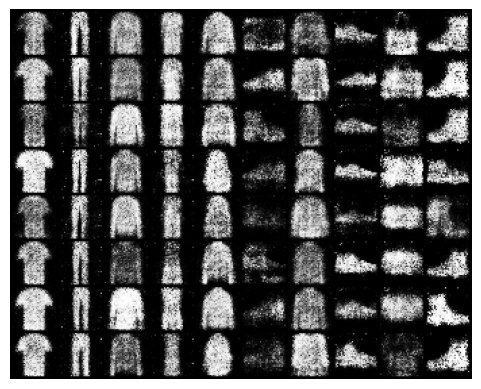

100%|█████████████████████████████████████████| 937/937 [00:12<00:00, 74.38it/s]


[Epoch: 4/30] [D loss: 0.9254] [G loss: 1.3343]


100%|████████████████████████████████████████▉| 936/937 [00:12<00:00, 73.96it/s]

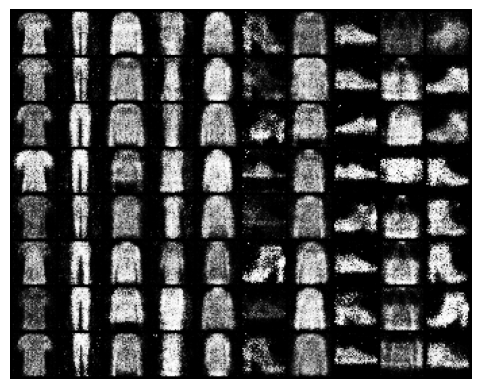

100%|█████████████████████████████████████████| 937/937 [00:12<00:00, 76.03it/s]


[Epoch: 5/30] [D loss: 0.8938] [G loss: 1.4043]


 99%|████████████████████████████████████████▋| 929/937 [00:12<00:00, 76.50it/s]

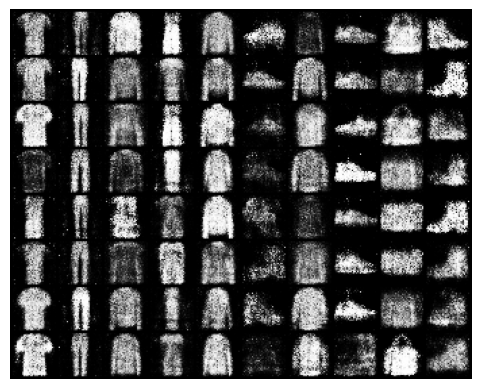

100%|█████████████████████████████████████████| 937/937 [00:12<00:00, 74.65it/s]


[Epoch: 6/30] [D loss: 0.8860] [G loss: 1.4526]


 99%|████████████████████████████████████████▋| 930/937 [00:12<00:00, 73.35it/s]

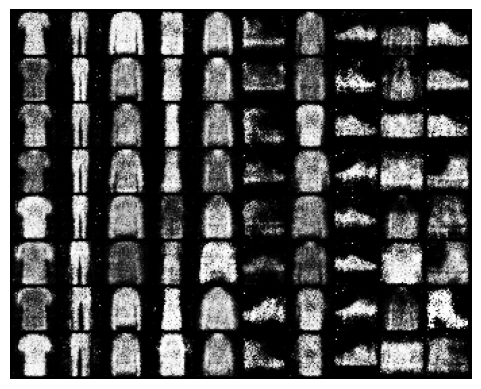

100%|█████████████████████████████████████████| 937/937 [00:12<00:00, 74.46it/s]


[Epoch: 7/30] [D loss: 0.8696] [G loss: 1.5075]


 99%|████████████████████████████████████████▋| 929/937 [00:12<00:00, 74.71it/s]

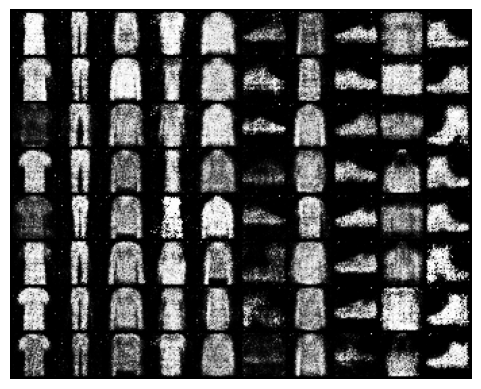

100%|█████████████████████████████████████████| 937/937 [00:12<00:00, 74.01it/s]


[Epoch: 8/30] [D loss: 0.8298] [G loss: 1.6106]


100%|████████████████████████████████████████▉| 936/937 [00:12<00:00, 75.98it/s]

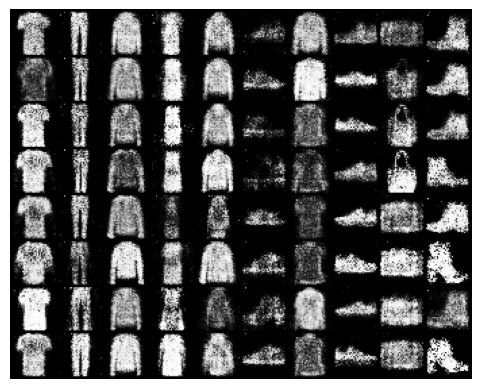

100%|█████████████████████████████████████████| 937/937 [00:12<00:00, 74.89it/s]


[Epoch: 9/30] [D loss: 0.7957] [G loss: 1.6920]


 99%|████████████████████████████████████████▋| 929/937 [00:12<00:00, 76.01it/s]

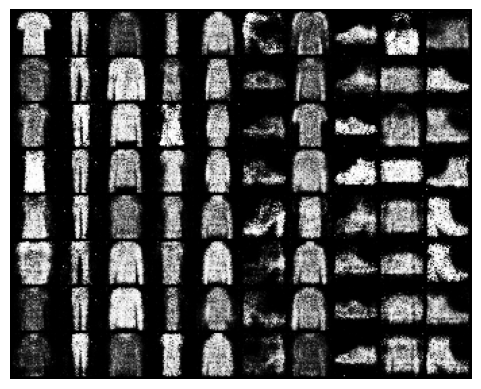

100%|█████████████████████████████████████████| 937/937 [00:12<00:00, 73.92it/s]


[Epoch: 10/30] [D loss: 0.7879] [G loss: 1.7510]


 99%|████████████████████████████████████████▊| 932/937 [00:12<00:00, 75.62it/s]

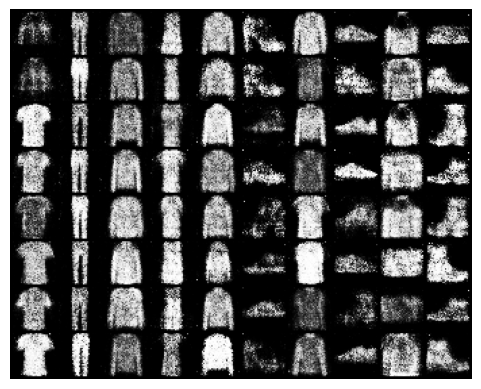

100%|█████████████████████████████████████████| 937/937 [00:12<00:00, 74.79it/s]


[Epoch: 11/30] [D loss: 0.7820] [G loss: 1.7871]


 99%|████████████████████████████████████████▊| 932/937 [00:12<00:00, 76.32it/s]

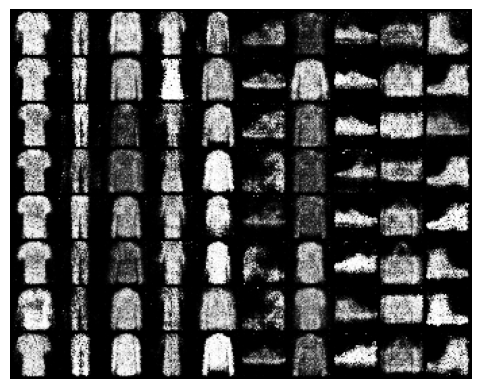

100%|█████████████████████████████████████████| 937/937 [00:12<00:00, 74.30it/s]


[Epoch: 12/30] [D loss: 0.7655] [G loss: 1.8381]


100%|████████████████████████████████████████▊| 933/937 [00:12<00:00, 75.92it/s]

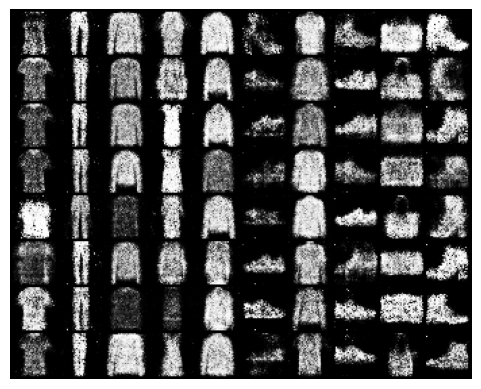

100%|█████████████████████████████████████████| 937/937 [00:12<00:00, 74.84it/s]


[Epoch: 13/30] [D loss: 0.7599] [G loss: 1.8974]


 99%|████████████████████████████████████████▋| 929/937 [00:12<00:00, 74.14it/s]

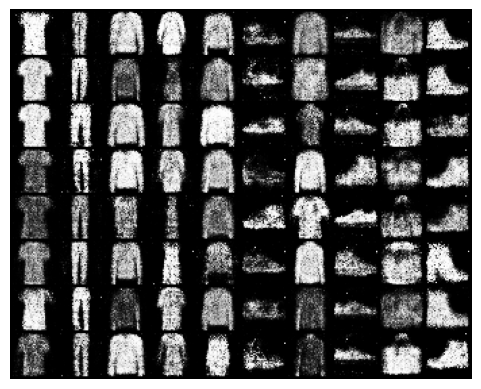

100%|█████████████████████████████████████████| 937/937 [00:12<00:00, 74.06it/s]


[Epoch: 14/30] [D loss: 0.7502] [G loss: 1.9267]


100%|████████████████████████████████████████▉| 936/937 [00:12<00:00, 75.00it/s]

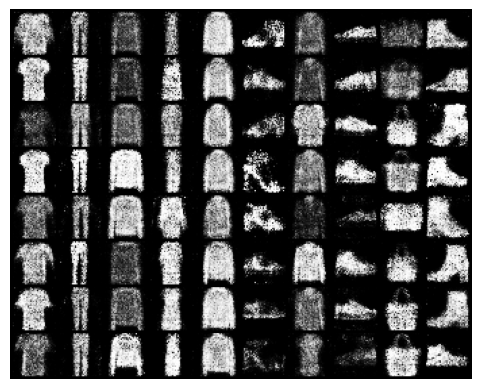

100%|█████████████████████████████████████████| 937/937 [00:12<00:00, 73.80it/s]


[Epoch: 15/30] [D loss: 0.7640] [G loss: 1.9260]


100%|████████████████████████████████████████▊| 934/937 [00:12<00:00, 74.91it/s]

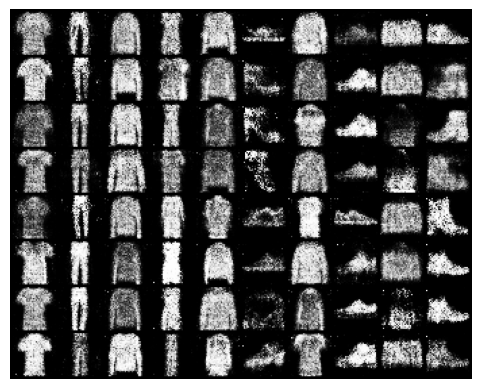

100%|█████████████████████████████████████████| 937/937 [00:12<00:00, 75.98it/s]


[Epoch: 16/30] [D loss: 0.7527] [G loss: 1.9715]


100%|████████████████████████████████████████▉| 936/937 [00:12<00:00, 74.27it/s]

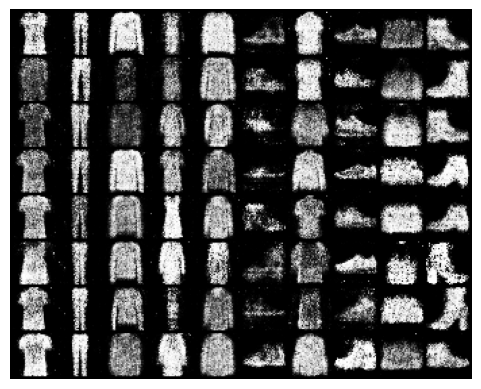

100%|█████████████████████████████████████████| 937/937 [00:12<00:00, 77.00it/s]


[Epoch: 17/30] [D loss: 0.7544] [G loss: 1.9824]


 99%|████████████████████████████████████████▋| 930/937 [00:11<00:00, 72.01it/s]

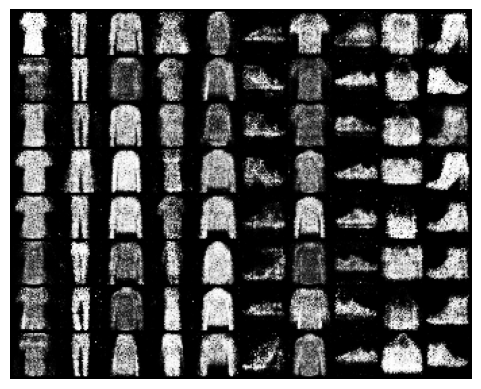

100%|█████████████████████████████████████████| 937/937 [00:11<00:00, 79.34it/s]


[Epoch: 18/30] [D loss: 0.7392] [G loss: 2.0307]


 99%|████████████████████████████████████████▊| 932/937 [00:12<00:00, 75.57it/s]

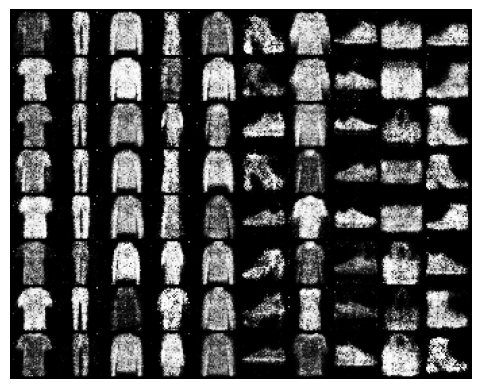

100%|█████████████████████████████████████████| 937/937 [00:12<00:00, 76.32it/s]


[Epoch: 19/30] [D loss: 0.7378] [G loss: 2.0627]


100%|████████████████████████████████████████▊| 933/937 [00:12<00:00, 73.50it/s]

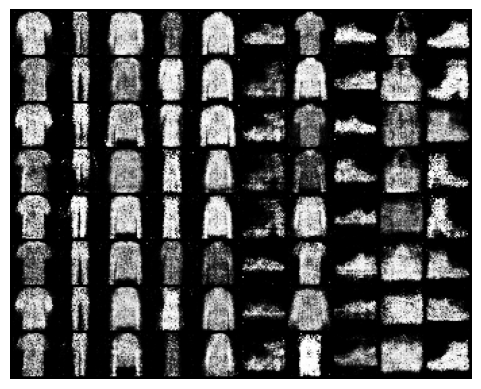

100%|█████████████████████████████████████████| 937/937 [00:12<00:00, 75.75it/s]


[Epoch: 20/30] [D loss: 0.7217] [G loss: 2.0939]


100%|████████████████████████████████████████▉| 935/937 [00:12<00:00, 75.56it/s]

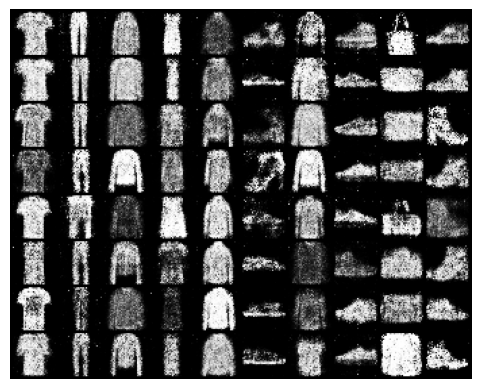

100%|█████████████████████████████████████████| 937/937 [00:12<00:00, 74.89it/s]


[Epoch: 21/30] [D loss: 0.7306] [G loss: 2.1077]


 99%|████████████████████████████████████████▋| 929/937 [00:11<00:00, 83.77it/s]

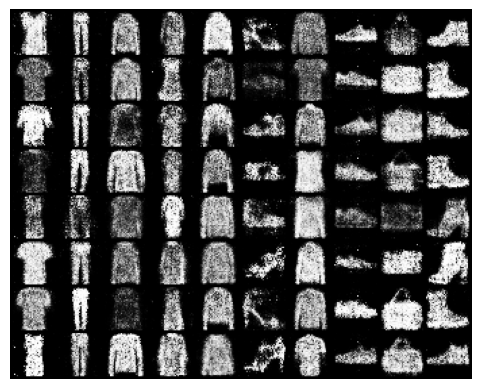

100%|█████████████████████████████████████████| 937/937 [00:11<00:00, 81.22it/s]


[Epoch: 22/30] [D loss: 0.7449] [G loss: 2.0951]


100%|████████████████████████████████████████▉| 936/937 [00:11<00:00, 74.76it/s]

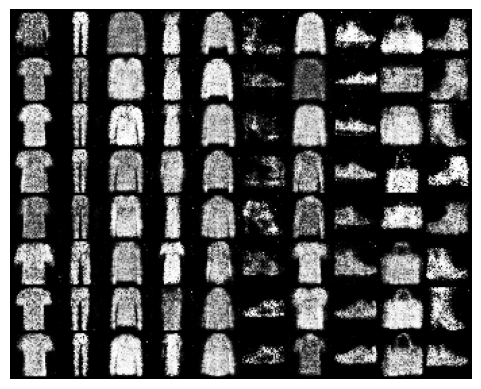

100%|█████████████████████████████████████████| 937/937 [00:11<00:00, 81.99it/s]


[Epoch: 23/30] [D loss: 0.7124] [G loss: 2.1540]


100%|████████████████████████████████████████▉| 935/937 [00:12<00:00, 75.06it/s]

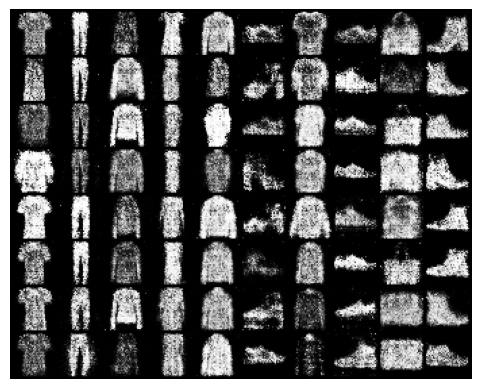

100%|█████████████████████████████████████████| 937/937 [00:12<00:00, 74.99it/s]


[Epoch: 24/30] [D loss: 0.7190] [G loss: 2.1759]


 99%|████████████████████████████████████████▋| 929/937 [00:12<00:00, 75.63it/s]

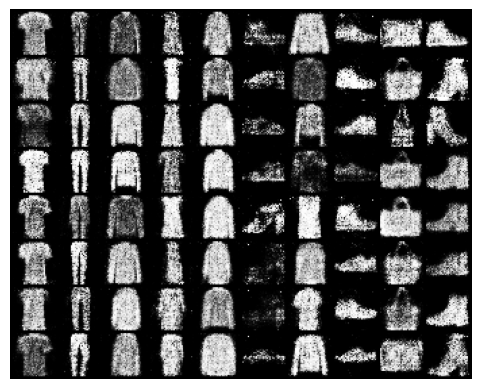

100%|█████████████████████████████████████████| 937/937 [00:12<00:00, 74.81it/s]


[Epoch: 25/30] [D loss: 0.7245] [G loss: 2.1724]


100%|████████████████████████████████████████▉| 935/937 [00:12<00:00, 77.94it/s]

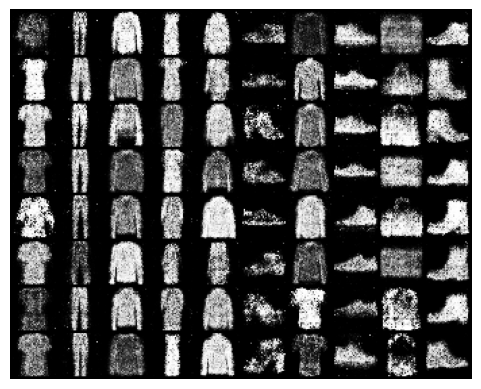

100%|█████████████████████████████████████████| 937/937 [00:12<00:00, 76.69it/s]


[Epoch: 26/30] [D loss: 0.7105] [G loss: 2.2028]


 99%|████████████████████████████████████████▋| 931/937 [00:12<00:00, 75.51it/s]

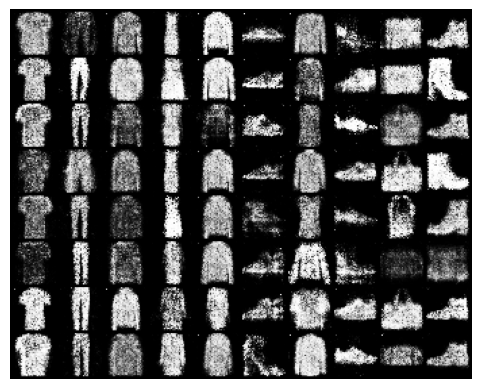

100%|█████████████████████████████████████████| 937/937 [00:12<00:00, 75.15it/s]


[Epoch: 27/30] [D loss: 0.7069] [G loss: 2.2373]


 99%|████████████████████████████████████████▌| 928/937 [00:11<00:00, 89.23it/s]

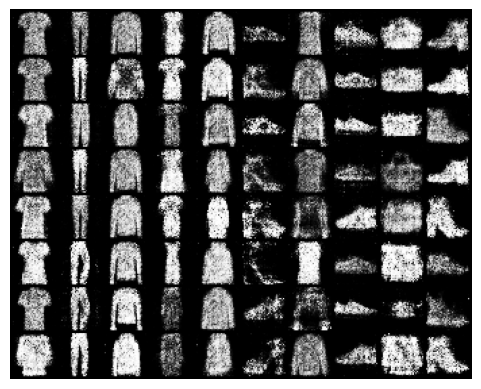

100%|█████████████████████████████████████████| 937/937 [00:11<00:00, 80.32it/s]


[Epoch: 28/30] [D loss: 0.7064] [G loss: 2.2600]


100%|████████████████████████████████████████▊| 934/937 [00:11<00:00, 90.92it/s]

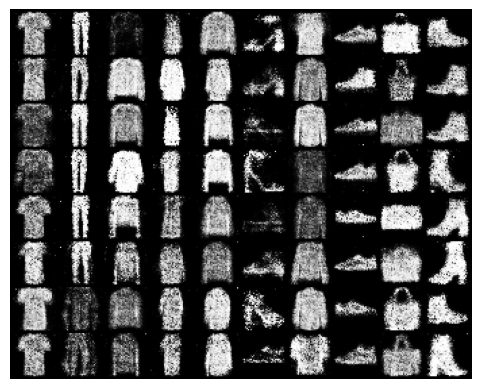

100%|█████████████████████████████████████████| 937/937 [00:11<00:00, 78.92it/s]


[Epoch: 29/30] [D loss: 0.7177] [G loss: 2.2453]


100%|████████████████████████████████████████▉| 935/937 [00:12<00:00, 74.57it/s]

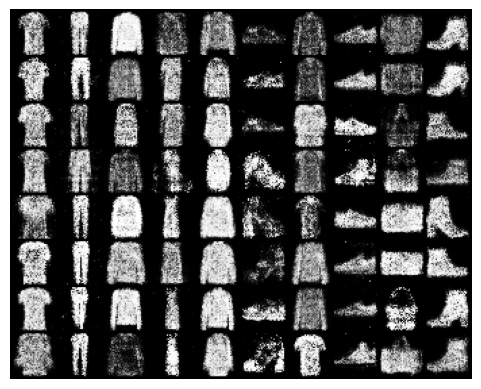

100%|█████████████████████████████████████████| 937/937 [00:12<00:00, 75.56it/s]

[Epoch: 30/30] [D loss: 0.6923] [G loss: 2.2908]


In [ ]:
cgan = ConditionalGANManager() # You can pass your arguments to the call.
cgan_history = cgan.train(dataloader, epochs=30)

### Visualize Loss

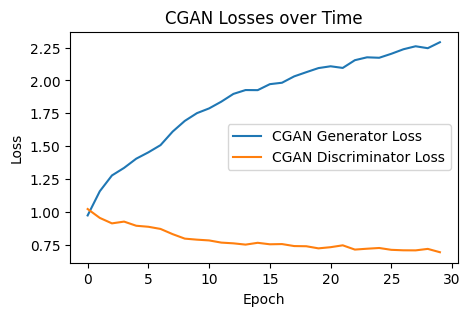

In [7]:
import matplotlib.pyplot as plt

def plot_losses(cgan_history):
    figsize = (5, 3)
    plt.figure(figsize=figsize)
    plt.plot(cgan_history['g_loss'], label='CGAN Generator Loss')
    plt.plot(cgan_history['d_loss'], label='CGAN Discriminator Loss')
    plt.title('CGAN Losses over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
plot_losses(cgan_history)